In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# On arakis, so elliptical orbits
# Ellipse is a parametric of t
def ellipse(t: np.ndarray, A: float=1, B: float=1) -> np.ndarray:
    """Get ellipse over time.

    Args:
        t (np.ndarray): The timeseries of timesteps.
        A (float, optional): X axis stretch factor. Defaults to 1.
        B (float, optional): Y axis stretch factor. Defaults to 1.

    Returns:
        np.ndarray: _description_
    """
    return np.array([A * np.cos(t), B * np.sin(t)])

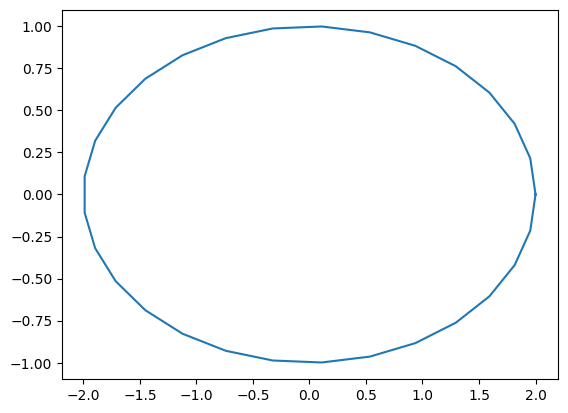

In [8]:
e = ellipse(np.linspace(0, 2*np.pi, 30), 2, 1)
plt.plot(e[0,:], e[1,:])

$F = m_{ss} * [m_other/(dist to other ** 2)]$

In [9]:
# State equation of the guild navigator's ship trying to get to Arakis and he's h*** on spice
# F = \sigma (gravity forces of each planet) 

def upd_ss(x: np.ndarray) -> np.ndarray:
    F = np.ndarray(
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
    )
    x = F@x
    return x

# F, A, B, Q, R, M
def LQR_formulation():
    pass #TODO first get the usual mechanics

In [6]:
# hello everyone